# Project description

Beta Bank customers are leaving every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon, using the data on clients’ past behavior and termination of contracts with the bank.

We'll build a model with the maximum possible F1 score (over 0.59).

# Data description

**Features**
- `RowNumber` — data string index
- `CustomerId` — unique customer identifier
- `Surname` — surname
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card
- `IsActiveMember` — customer’s activeness
- `EstimatedSalary` — estimated salary

**Target**
- `Exited` — сustomer has left

# Library imports

In [1]:
#Libraries and project environment setup:

##Pandas, Numpy, Re and Datetime for data preprocessing and manipulation
import pandas as pd
import numpy as np
import re
import datetime
from datetime import datetime

##Remove warnings
import sys
import warnings
if not sys.warnoptions:
   warnings.simplefilter("ignore");

##Scipy, Math and Random for SDA
from scipy import stats as st
from scipy.stats import loguniform
import math as mth
import random

##Matplotlib, Seaborn, Plotly, Altair and Streamlit for visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly import tools
import plotly.offline as py
import altair as alt
import streamlit as sl
from IPython.display import Image

#USAddress for handling USA addresses in DF
import usaddress

#SKLearn and JobLib for ML
import sklearn
from sklearn.datasets import make_blobs
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler as ss
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
import joblib
from joblib import dump

# CSV file read

In [2]:
#We use try-except to handle unexpected errors
try:
    df=pd.read_csv('/Downloads/Churn.csv')

except:
    df=pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

# General info

In [3]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df.drop_duplicates(inplace=True,keep='last')
df.reset_index(drop=True, inplace=True)

#Print the first five entries in the dataframe
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


- No NaN values.
- `RowNumber` and `CustomerId` columns are practically indexes, we'll drop these columns and keep the automatic index.
- `Surname` doesn't impact target, so it will be dropped.

In [4]:
#General file examination (missing values and data types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 10000 entries and 14 columns.
- 909 missing values in `Tenure` column.
- Data types seem fine.

In [5]:
#Integrated display of the columns
df.describe(include='all')

2022-09-09 19:27:15.575 INFO    numexpr.utils: NumExpr defaulting to 4 threads.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


- Target is binary, 1-exited and 0-customer. Customers mostly stayed and there is a class imbalance, to be dealt with.

# Preprocessing

## RowNumber, CustomerId and Surname

In [6]:
#Dropping columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

## Tenure

In [7]:
#Taking a closer look at tenure values and missing values
print(df['Tenure'].isnull().sum()/len(df)*100, '\n')
print(df['Tenure'].value_counts())

9.09 

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64


Values are practically integers, we'll fill the 9.09% of missing values and then convert data type from float to integer.

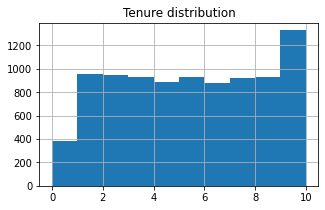

In [8]:
#Plotting tenure distribution
df['Tenure'].hist(figsize=(5,3))
plt.title('Tenure distribution');

In [9]:
#Filling missing values with mean per NumOfProducts group
df['Tenure'] = df.groupby('NumOfProducts')['Tenure'].apply(lambda x: x.fillna(x.mean()))
df['Tenure'].isnull().sum()

0

In [10]:
#Converting tenure values to integer data type
df['Tenure'] = df['Tenure'].astype(int)

## Categorical features encoding

In [11]:
#Taking closer look at geography values
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

`Geography` has 3 countries, to be encoded using OHE.

In [12]:
#Taking closer look at gender values
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

`Gender` is binary. OHE will be used here as well.

In [13]:
#Dropping first column per encoded feature to avoid dummy trap
df_OHE = pd.get_dummies(df, drop_first=True)
df_OHE.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


# EDA - class balance

## CreditScore

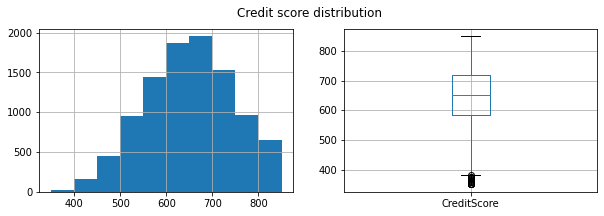

In [14]:
#Plotting credit score distribution
plt.subplot(1, 2, 1)
df['CreditScore'].hist(figsize=(10,3))
plt.suptitle('Credit score distribution');
plt.subplot(1, 2, 2)
df.boxplot('CreditScore');

Distribution close to normal.

## Geography

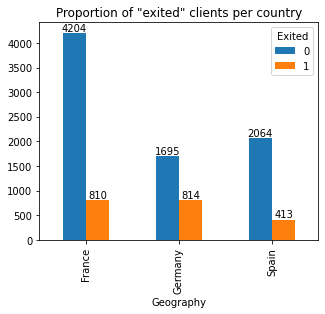

In [15]:
#Plotting geography distribution
ax=df.groupby(['Geography', 'Exited']).size().unstack().plot.bar(figsize=(5,4))
plt.title('Proportion of "exited" clients per country')
for container in ax.containers:
    ax.bar_label(container);

Most customers are in France and also exit the least. Germany has the highest churn rate.

## Gender

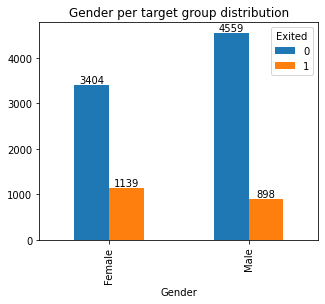

In [16]:
#Plotting gender distribution
ax=df.groupby(['Gender', 'Exited']).size().unstack().plot.bar(figsize=(5,4))
plt.title('Gender per target group distribution');
for container in ax.containers:
    ax.bar_label(container);

Most customers are male and female customers are more likely to leave.

## Age

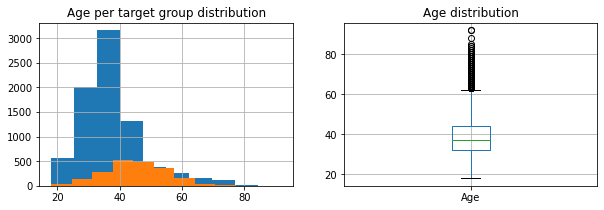

In [17]:
#Plotting age distribution
plt.subplot(1, 2, 1)
df.groupby('Exited')['Age'].hist(figsize=(10,3))
plt.title('Age per target group distribution');
plt.subplot(1, 2, 2)
df.boxplot('Age')
plt.title('Age distribution');

Most customers are about 30-40 years old, distribution is positively skewed. Distribution of customers that have exited (orange) is closer to normal than that of loyal customers.

## Balance

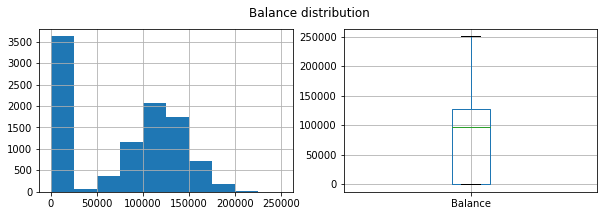

In [18]:
#Plotting balance distribution
plt.subplot(1, 2, 1)
df['Balance'].hist(figsize=(10,3))
plt.suptitle('Balance distribution');
plt.subplot(1, 2, 2)
df.boxplot('Balance');

In [19]:
#Taking closer look at all values when balance=0
df[df['Balance']==0].head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,476,France,Female,34,10,0.0,2,1,0,26260.98,0


Distribution shows high number of 0 values. This may be due to customers that have exited or simply customers with a balance of 0.

## EstimatedSalary

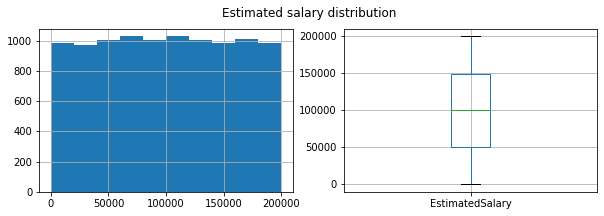

In [20]:
#Plotting estimated salary distribution
plt.subplot(1, 2, 1)
df['EstimatedSalary'].hist(figsize=(10,3))
plt.suptitle('Estimated salary distribution');
plt.subplot(1, 2, 2)
df.boxplot('EstimatedSalary');

No visible outliers.

## Exited - Target

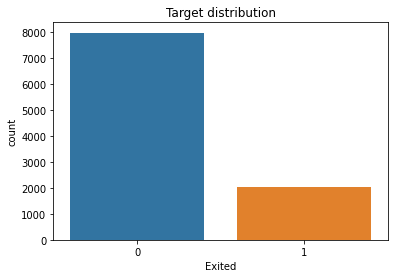

In [21]:
#Plotting exited distribution
sns.countplot(df['Exited'])
plt.title('Target distribution');

Classes are imbalanced with over twice the existing customers (blue) compared to those who exited.

# Training

Now we'll calculate the baseline F1 score and run models without taking the imbalance into consideration.

## Splitting data into train, validation and test sets

In [22]:
#Splitting data into train and test sets (X- features, y-target)
X = df_OHE.drop('Exited', axis=1)
y = df_OHE['Exited']
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=12345)

Stratify parameter splits such that produced sample values' proportion is the same as provided values' proportion.

For example, if y is binary categorical with 25% of zeros and 75% of ones, stratify=y will make random splits into 25% of 0's and 75% of 1's.

In [23]:
#Splitting train set into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size = 0.25, random_state=12345)

In [24]:
#Naming sets
X_test.name = 'X_test'
X_valid.name = 'X_valid'
y_train.name = 'y_train'
y_valid.name = 'y_valid'
y_test.name = 'y_test'
X_train.name = 'X_train'

In [25]:
#Checking set size
for part in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    print("Size of", part.name, ":", part.shape[0]/df.shape[0])

Size of X_train : 0.6
Size of y_train : 0.6
Size of X_valid : 0.2
Size of y_valid : 0.2
Size of X_test : 0.2
Size of y_test : 0.2


Source data successfully split into sets.

## Standard Scaling

In [26]:
#Standard Scaling
sc = ss()
X_train_scaled = sc.fit_transform(X_train)
X_valid_scaled = sc.transform(X_valid)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(data=X_train_scaled,
                        index=X_train.index,    
                        columns=X_train.columns) 

X_valid = pd.DataFrame(data=X_valid_scaled,    
                        index=X_valid.index,    
                        columns=X_valid.columns)  

X_test = pd.DataFrame(data=X_test_scaled,   
                        index=X_test.index,    
                        columns=X_test.columns) 

StandardScaler transforms data so distribution has mean value 0 and std 1.

## Models with class imbalance

### Preliminary F1 score (baseline)

In [27]:
#Dummy classification to check baseline
dummy = DummyClassifier(strategy='constant', constant=1, random_state=12345)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_valid)
f1_dummy = round(f1_score(y_valid,y_pred) * 100, 2)
print("Baseline F1 score:", f1_dummy)

Baseline F1 score: 34.98


The model should correctly predict the minority class - whether a customer exited, therefore we chose the strategy `constant` for the dummy classifier.

To pass the sanity check our model must result in a score of 34% F1 or above.

### Decision Tree Classifier

In [28]:
#Checking default F1
dtc = DecisionTreeClassifier(random_state=12345)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_valid)

f1_dtc_imbalanced = round(f1_score(y_valid,y_pred) * 100, 2)
f1_dtc_imbalanced

49.19

### Random Forest Classifier

In [29]:
#Checking default F1
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_valid)

f1_rfc_imbalanced = round(f1_score(y_valid,y_pred) * 100, 2)
f1_rfc_imbalanced

55.94

### Logistic Regression

In [30]:
#Checking default F1
lr = LogisticRegression(random_state=12345)
lr.fit(X_train, y_train)     
y_pred = lr.predict(X_valid)

f1_lr_imbalanced = round(f1_score(y_valid,y_pred) * 100, 2)
f1_lr_imbalanced

31.9

All 3 models resulted in a score lower than the 59% target. Default Logistic Regression was lower than the dummy classifier. Now we'll tune and run the models again after we've dealt with the imbalance using:
- Class Weight Adjustment.
- Upsampling.
- Downsampling.

## Class imbalance correction and hyperparameter tuning

### Method 1: Class Weight Adjustment

#### Decision Tree Classifier

In [31]:
#Running loop to find best hyperparameters
d = []
for depth in range(1,10):
    dtc = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_valid)
    f1_dtc_balanced = round(f1_score(y_valid,y_pred) * 100, 2)
    d.append({'max_depth': depth, 'f1_dtc_balanced': f1_dtc_balanced})

best_param = pd.DataFrame(d).nlargest(1, ['f1_dtc_balanced'], keep='first')
f1_dtc_balanced = best_param['f1_dtc_balanced'].values
best_param

,max_depth,f1_dtc_balanced
5,6,59.09


#### Random Forest Classifier

In [32]:
#Running loop to find best hyperparameters
d = []
for estim in range(1,51,9):
    for depth in range(1,10):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth, class_weight='balanced')
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_valid)
        f1_rfc_balanced = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'n_estimators': estim, 'max_depth': depth, 'f1_rfc_balanced': f1_rfc_balanced})

best_param = pd.DataFrame(d).nlargest(1, ['f1_rfc_balanced'], keep='first')
f1_rfc_balanced = best_param['f1_rfc_balanced'].values
best_param

,n_estimators,max_depth,f1_rfc_balanced
35,28,9,63.09


#### Logistic Regression

In [33]:
#Running loop to find best hyperparameters
d = []
for penalty in ['l1', 'l2']:
    for C in np.arange(0.01,1,0.01):
        lr = LogisticRegression(solver="liblinear", penalty=penalty, class_weight='balanced', C=C, random_state=12345)
        lr.fit(X_train, y_train)     
        y_pred = lr.predict(X_valid)
        f1_lr_balanced = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'penalty': penalty, 'C': C, 'f1_lr_balanced': f1_lr_balanced})
        
best_param = pd.DataFrame(d).nlargest(1, ['f1_lr_balanced'], keep='first')
f1_lr_balanced = best_param['f1_lr_balanced'].values
best_param

,penalty,C,f1_lr_balanced
99,l2,0.01,50.59


### Method 2: Upsampling

In [34]:
#Defining upsample function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 10)

#### Decision Tree Classifier

In [35]:
#Running loop to find best hyperparameters
d = []
for depth in range(1,10):
    dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dtc.fit(X_train_upsampled, y_train_upsampled)
    y_pred = dtc.predict(X_valid)
    f1_dtc_upsampled = round(f1_score(y_valid,y_pred) * 100, 2)
    d.append({'max_depth': depth, 'f1_dtc_upsampled': f1_dtc_upsampled})

best_param = pd.DataFrame(d).nlargest(1, ['f1_dtc_upsampled'], keep='first')
f1_dtc_upsampled = best_param['f1_dtc_upsampled'].values
best_param

,max_depth,f1_dtc_upsampled
5,6,54.14


#### Random Forest Classifier

In [36]:
#Running loop to find best hyperparameters
d = []
for estim in range(1,51,9):
    for depth in range(1,10):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        rfc.fit(X_train_upsampled, y_train_upsampled)
        y_pred = rfc.predict(X_valid)
        f1_rfc_upsampled = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'n_estimators': estim, 'max_depth': depth, 'f1_rfc_upsampled': f1_rfc_upsampled})

best_param = pd.DataFrame(d).nlargest(1, ['f1_rfc_upsampled'], keep='first')
f1_rfc_upsampled = best_param['f1_rfc_upsampled'].values
best_param

,n_estimators,max_depth,f1_rfc_upsampled
44,37,9,56.65


#### Logistic Regression

In [37]:
#Running loop to find best hyperparameters
d = []
for penalty in ['l1', 'l2']:
    for C in np.arange(0.01,1,0.01):
        lr = LogisticRegression(solver="liblinear", penalty=penalty, C=C, random_state=12345)
        lr.fit(X_train_upsampled, y_train_upsampled)     
        y_pred = lr.predict(X_valid)
        f1_lr_upsampled = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'penalty': penalty, 'C': C, 'f1_lr_upsampled': f1_lr_upsampled})
        
best_param = pd.DataFrame(d).nlargest(1, ['f1_lr_upsampled'], keep='first')
f1_lr_upsampled = best_param['f1_lr_upsampled'].values
best_param

,penalty,C,f1_lr_upsampled
91,l1,0.92,42.4


### Method 3: Downsampling 

In [38]:
#Defining downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

X_train_downsampled, y_train_downsampled = downsample(X_train, y_train, 0.1)

#### Decision Tree Classifier

In [39]:
#Running loop to find best hyperparameters
d = []
for depth in range(1,10):
    dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dtc.fit(X_train_downsampled, y_train_downsampled)
    y_pred = dtc.predict(X_valid)
    f1_dtc_downsampled = round(f1_score(y_valid,y_pred) * 100, 2)
    d.append({'max_depth': depth, 'f1_dtc_downsampled': f1_dtc_downsampled})

best_param = pd.DataFrame(d).nlargest(1, ['f1_dtc_downsampled'], keep='first')
f1_dtc_downsampled = best_param['f1_dtc_downsampled'].values
best_param

,max_depth,f1_dtc_downsampled
4,5,55.05


#### Random Forest Classifier

In [40]:
#Running loop to find best hyperparameters
d = []
for estim in range(1,51,9):
    for depth in range(1,10):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        rfc.fit(X_train_downsampled, y_train_downsampled)
        y_pred = rfc.predict(X_valid)
        f1_rfc_downsampled = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'n_estimators': estim, 'max_depth': depth, 'f1_rfc_downsampled': f1_rfc_downsampled})

best_param = pd.DataFrame(d).nlargest(1, ['f1_rfc_downsampled'], keep='first')
f1_rfc_downsampled = best_param['f1_rfc_downsampled'].values
best_param

,n_estimators,max_depth,f1_rfc_downsampled
8,1,9,49.42


#### Logistic Regression

In [41]:
#Running loop to find best hyperparameters
d = []
for penalty in ['l1', 'l2']:
    for C in np.arange(0.01,1,0.01):
        lr = LogisticRegression(solver="liblinear", penalty=penalty, C=C, random_state=12345)
        lr.fit(X_train_downsampled, y_train_downsampled)     
        y_pred = lr.predict(X_valid)
        f1_lr_downsampled = round(f1_score(y_valid,y_pred) * 100, 2)
        d.append({'penalty': penalty, 'C': C, 'f1_lr_downsampled': f1_lr_downsampled})
        
best_param = pd.DataFrame(d).nlargest(1, ['f1_lr_downsampled'], keep='first')
f1_lr_downsampled = best_param['f1_lr_downsampled'].values
best_param

,penalty,C,f1_lr_downsampled
127,l2,0.29,42.41


# Selecting

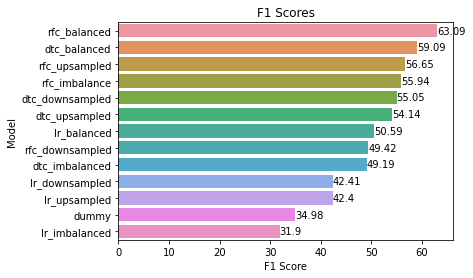

In [42]:
#Creating DF of default and tuned model scores
models = pd.DataFrame({
    'Model': ['dummy', 'dtc_imbalanced', 'lr_imbalanced', 'rfc_imbalance', 'dtc_balanced','lr_balanced',
              'rfc_balanced', 'dtc_upsampled','lr_upsampled','rfc_upsampled', 'dtc_downsampled','lr_downsampled',
              'rfc_downsampled'],
    'Score': [f1_dummy, f1_dtc_imbalanced, f1_lr_imbalanced, f1_rfc_imbalanced, f1_dtc_balanced, f1_lr_balanced, 
              f1_rfc_balanced, f1_dtc_upsampled, f1_lr_upsampled, f1_rfc_upsampled, f1_dtc_downsampled, 
              f1_lr_downsampled, f1_rfc_downsampled]})
sorted_by_score = models.sort_values(by='Score', ascending=False)
sorted_by_score['Score']=sorted_by_score['Score'].astype('float')

#Plotting
ax=sns.barplot(x='Score', y = 'Model', data = sorted_by_score)
ax.bar_label(ax.containers[0])
plt.title('F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Model');

The highest F1 score are for **rfc_balanced** and **dtc_balanced**, both using Class Weight Adjustment to handle the class imbalance. 

Random forest classifier uses multiple decision trees and picks features randomly during the training process, without depending on any specific feature set.

# Testing

In [43]:
#Standard Scaling
X_train_all_scaled = sc.fit_transform(X_train_all)

#Running test
rfc = RandomForestClassifier(n_estimators=46, max_depth=7, random_state=12345, class_weight='balanced')
rfc.fit(X_train_all_scaled, y_train_all)
y_pred = rfc.predict(X_test)

f1_rfc = round(f1_score(y_test,y_pred) * 100, 2)
f1_rfc

63.58

# Sanity check

The final RandomForestClassifier F1 score is 28.85% higher than the F1 baseline score of the DummyClassifier.

# AUC-ROC

In [44]:
#Calculating AUC-ROC score (Area Under Curve Receiver Operating Characteristic)
probabilities_test = rfc.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = round(roc_auc_score(y_test, probabilities_one_test) * 100, 2)
auc_roc

86.58

The AUC-ROC score is high, meaning our predictions are over 80% correct.

The ROC curve takes the target values and the positive class probabilities, goes over different thresholds, and returns three lists: FPR values, TPR values, and the thresholds it went over.

For a model that always answers randomly, the ROC curve is a diagonal line going from the lower left to the upper right. The higher the curve, the greater the TPR value and the better the model's quality.

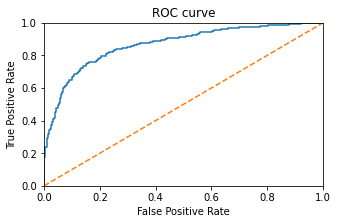

In [45]:
#Plotting
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 

plt.figure(figsize=(5,3))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC curve');

ROC curve is higher than the diagonal, which is a good sign.

# Conclusion

This project was about building a model with the maximum possible F1 score. 

We followed the methodology as follows:
- Open data file and study general information.
- Data preprocessing.
- Split source data into sets.
- Correct class imbalance (class weight adjustment, upsampling, downsampling).
- Tune hyperparameters.
- Investigate model quality by F1 score.
- Find best model.
- Testing with test set.
- Model sanity check using DummyClassifier.
- Calculate and plot AUC-ROC.
- And now, final conclusion.

Findings:
- No outliers.
- Most customers are in France and also exit the least. Germany has the highest churn rate.
- Most customers are about 30-40 years old, distribution is positively skewed. 
- Most customers are male and are less likely to leave.
- AUC-ROC is 86.66%, meaning our predictions are over 80% correct. ROC curve is higher than the diagonal which is a good sign.

Results of tunning 3 learning algorithms (DecisionTreeClassifier, RandomForestClassifier and Logistic Regression) using training set indicated that RandomForestClassifier model has the highest F1 score of 63.26%. Further the model was retrained on the entire training set including validation set. Afterwards model was tested using the test set and reached 63.83%. 

Finally, model sanity check successfully resulted in the test score being 28.85% higher than the baseline score.

In conclusion of this task, we indeed developed a model to predict whether a customer will leave the bank soon.